# Comparing fPCA Using Other Base Functions

## Load Modules and Data

In [1]:
import os 
import pandas as pd
import numpy as np
from loadData import load_profile, smooth
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from skfda.exploratory.visualization import FPCAPlot

In [2]:
def load_transcript():
    tss = pd.read_csv(
        'data/ref/GSE49026_S-TSS.txt',
        delimiter='\t',
        usecols=['chr', 'coordinate', 'ORF']
    )
    tss.columns = ['chr', 'start', 'ORF']
    pas = pd.read_csv(
        'data/ref/GSE49026_S-PAS.txt',
        delimiter='\t',
        usecols=['coordinate', 'ORF']
    )
    pas.columns = ['end', 'ORF']
    combined_df = pd.merge(left=tss, right=pas, left_on='ORF', right_on='ORF')
    combined_df['size'] = np.abs(combined_df['start'] - combined_df['end'])
    return combined_df

In [3]:
wt_ocampo_a = load_profile('data/mat/Ocampo_WT_A/')
wt_ocampo_b = load_profile('data/mat/Ocampo_WT_B/')
drop_list = ['cluster', 'ORF']
ocampo_a_fd = FDataGrid(
    data_matrix=wt_ocampo_a.drop(drop_list, axis=1).to_numpy(),
    grid_points=np.arange(wt_ocampo_a.drop(drop_list, axis=1).to_numpy().shape[1]),
)

ocampo_b_fd = FDataGrid(
    data_matrix=wt_ocampo_b.drop(drop_list, axis=1).to_numpy(),
    grid_points=np.arange(wt_ocampo_b.drop(drop_list, axis=1).to_numpy().shape[1]),
)

## Use Different Numbers of BSplines

In [4]:
bspline_basis_5 = BSplineBasis(n_basis=5)
bspline_basis_10 = BSplineBasis(n_basis=10)
bspline_basis_20 = BSplineBasis(n_basis=20)
bspline_basis_50 = BSplineBasis(n_basis=50)
bspline_basis_100 = BSplineBasis(n_basis=100)
all_bsplines = [bspline_basis_5, bspline_basis_10, 
                bspline_basis_20, bspline_basis_50, bspline_basis_100]
bspline_names = ['5 BSplines', '10 BSplines', '20 BSplines', '50 BSplines', '100 BSplines']

### Overall Difference 

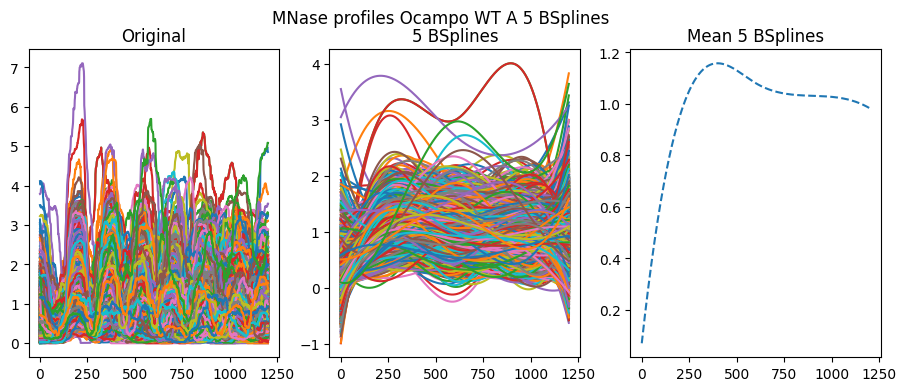

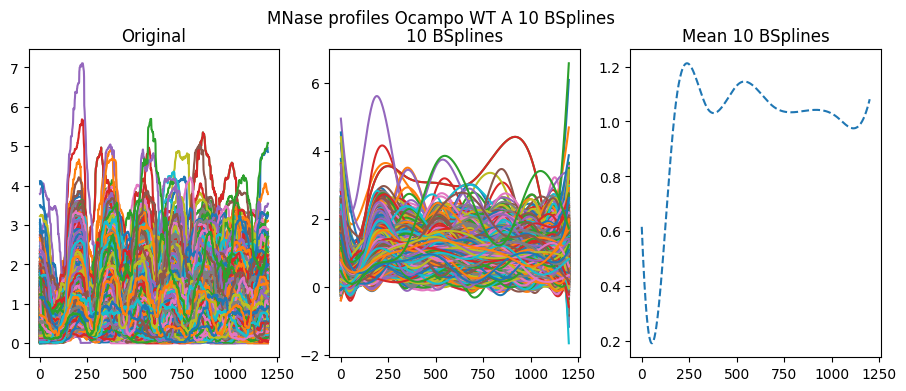

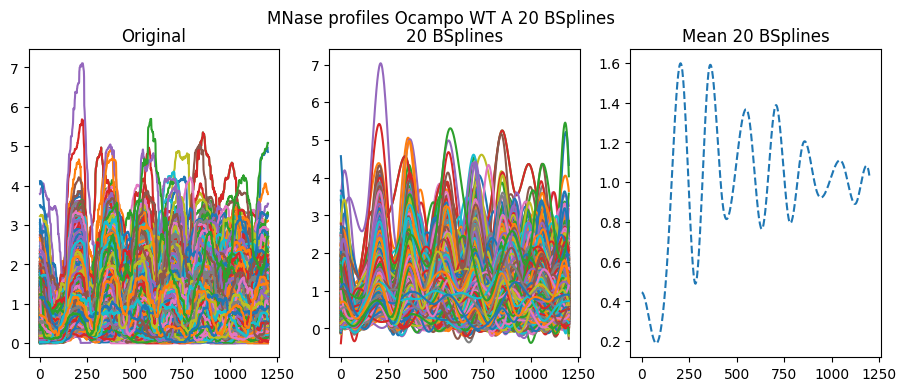

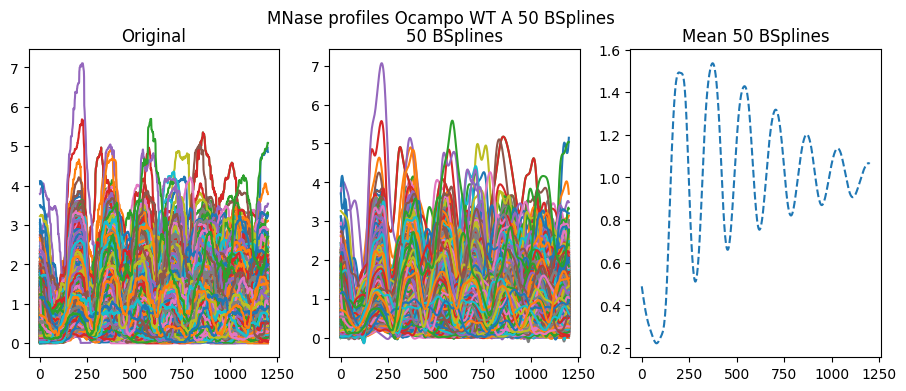

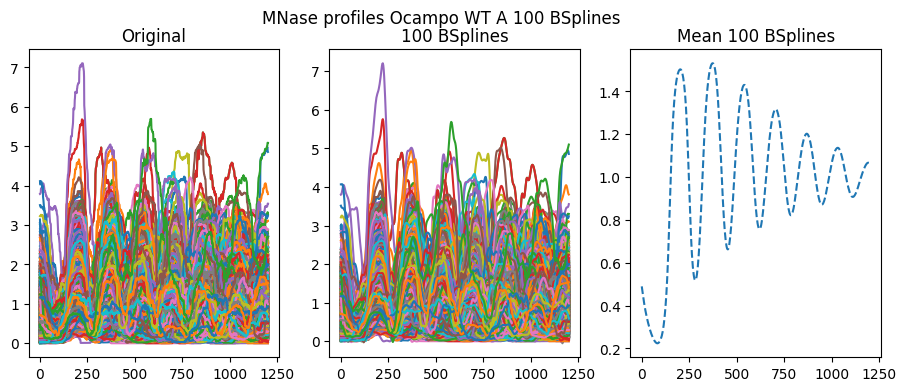

In [5]:
all_bsplines_ocampo_A = []
for bsplines, bs_name in zip(all_bsplines, bspline_names):
    all_bsplines_ocampo_A.append(ocampo_a_fd.to_basis(bsplines))
    fig, ax = plt.subplots(1, 3, figsize=(11, 4))
    ax[0].plot(wt_ocampo_a.drop(drop_list, axis=1).to_numpy().T)
    all_bsplines_ocampo_A[-1].plot(chart=ax[1])
    all_bsplines_ocampo_A[-1].mean().plot(chart=ax[2], linestyle='--')
    fig.suptitle('MNase profiles Ocampo WT A %s' % bs_name)
    ax[0].set_title('Original')
    ax[1].set_title(bs_name)
    ax[2].set_title('Mean %s' % bs_name)
    plt.show()

### Difference For a Single Gene As Example

5 BSplines fPC 1 explained ratio: 0.40952
5 BSplines fPC 2 explained ratio: 0.22092
10 BSplines fPC 1 explained ratio: 0.27539
10 BSplines fPC 2 explained ratio: 0.15054
20 BSplines fPC 1 explained ratio: 0.21365
20 BSplines fPC 2 explained ratio: 0.11542
50 BSplines fPC 1 explained ratio: 0.20790
50 BSplines fPC 2 explained ratio: 0.11171
100 BSplines fPC 1 explained ratio: 0.20628
100 BSplines fPC 2 explained ratio: 0.11087


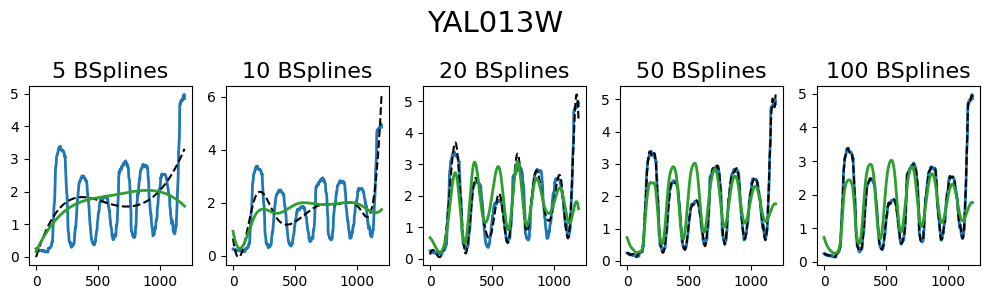

In [6]:
idx = 10
bspline_fpca_scores_ocampo_a = []
fig, ax = plt.subplots(1, 5, figsize=(10, 3))
for bsplines_ocampo, bs_name, a in zip(all_bsplines_ocampo_A, bspline_names, ax.reshape(-1)):
    fpca_ocampo_bspline = FPCA(n_components=2)
    bspline_fpca_scores_ocampo_a.append(fpca_ocampo_bspline.fit_transform(bsplines_ocampo))
    print('%s fPC 1 explained ratio: %.5f' % (bs_name, fpca_ocampo_bspline.explained_variance_ratio_[0]))
    print('%s fPC 2 explained ratio: %.5f' % (bs_name, fpca_ocampo_bspline.explained_variance_ratio_[1]))
    a.plot(wt_ocampo_a.iloc[idx].drop(drop_list), lw=2)
    bsplines_ocampo[idx].plot(chart=a, linestyle='--', color='black')
    (bsplines_ocampo.mean()
     + fpca_ocampo_bspline.components_[0] * bspline_fpca_scores_ocampo_a[-1][idx][0] 
     + fpca_ocampo_bspline.components_[1] * bspline_fpca_scores_ocampo_a[-1][idx][1]
    ).plot(chart=a, color='tab:green', lw=2)
    a.set_title(bs_name, fontsize=16)
fig.suptitle(wt_ocampo_a.iloc[idx]['ORF'], fontsize=21)
fig.tight_layout()
plt.show()    

### Difference With Respect to fPCA Scores and Clustering

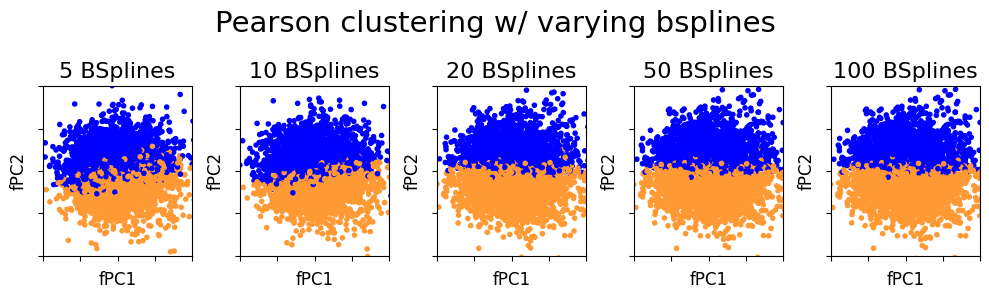

In [7]:
colors = np.array([[0., 0., 1., 1., ], [1., .6, .2, 1., ]])
fig, ax = plt.subplots(1, 5, figsize=(10, 3))
for bspline_scores, bs_name, a in zip(bspline_fpca_scores_ocampo_a, bspline_names, ax.reshape(-1)):
    did_swap = False
    if np.sum(np.sign(bspline_scores[wt_ocampo_a['cluster'] == 1, 1])) < 0:
        colors = np.flip(colors, axis=0)
        did_swap = True
    a.scatter(*bspline_scores.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')
    if did_swap:
        colors = np.flip(colors, axis=0)
    a.set_ylim((-20, 20))
    a.set_xlim((-20, 20))
    a.set_xlabel('fPC1', fontsize=12)
    a.set_ylabel('fPC2', fontsize=12)
    a.set_xticks(np.arange(-20, 21, 10))
    a.set_xticklabels([])
    a.set_yticks(np.arange(-20, 21, 10))
    a.set_yticklabels([])
    a.set_title(bs_name, fontsize=16)
fig.suptitle('Pearson clustering w/ varying bsplines', fontsize=21)
fig.tight_layout()
plt.show()

### ANOVA Test

In [8]:
def calc_explicability(pred, data, n_base, n_points=1200):
    return np.mean((pred - data)**2) / (n_points - n_base - 1)

In [9]:
explanability_list = []
wt_ocampo_a_data = wt_ocampo_a.drop(drop_list, axis=1).to_numpy()
x_range = np.arange(wt_ocampo_a_data.shape[1])
for bspline, n_bsp in zip(all_bsplines_ocampo_A, [5, 10, 20, 50, 100]):
    bspline_explanability_list = []
    fpca_bspline = FPCA(n_components=2)
    scores = fpca_bspline.fit_transform(bspline)
    for func_idx in range(len(wt_ocampo_a.index)):
        orig_data = wt_ocampo_a_data[func_idx]
        func_estim = (
            bspline.mean() 
            + fpca_bspline.components_[0] * scores[func_idx][0] 
            + fpca_bspline.components_[1] * scores[func_idx][1]
        )(x_range).reshape(-1)
        bspline_explanability_list.append(calc_explicability(func_estim, orig_data, n_bsp))
    explanability_list.append(bspline_explanability_list)

In [10]:
for explanability, bs_name in zip(explanability_list, bspline_names):
    # Add scaling for simple readability
    print('ANOVA explainability %s: %.5f' % (bs_name, np.median(explanability) * 1000)) 

ANOVA explainability 5 BSplines: 0.16331
ANOVA explainability 10 BSplines: 0.15649
ANOVA explainability 20 BSplines: 0.10836
ANOVA explainability 50 BSplines: 0.10659
ANOVA explainability 100 BSplines: 0.11143


## Comparison W/ Other Base Functions

In [11]:
from skfda.representation.basis import FourierBasis, MonomialBasis

In [12]:
fourier_basis = FourierBasis(n_basis=20)
monomial_basis = MonomialBasis(n_basis=20)
all_basis = [bspline_basis_20, fourier_basis, monomial_basis]
basis_names = ['BSplines', 'Fourier', 'Monomial']

### Overall Difference

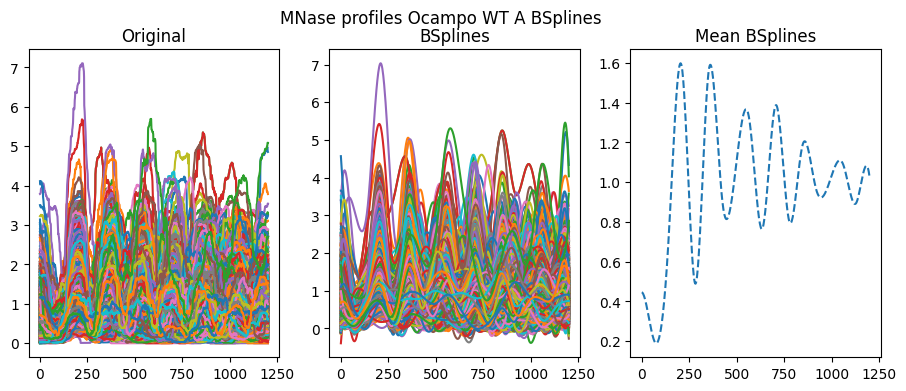

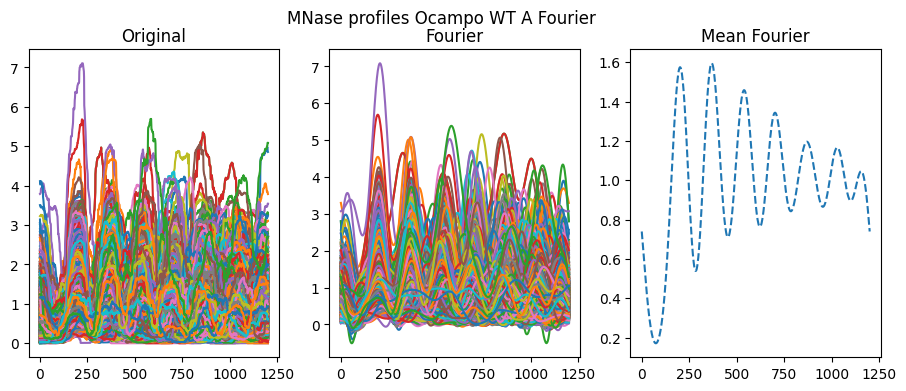

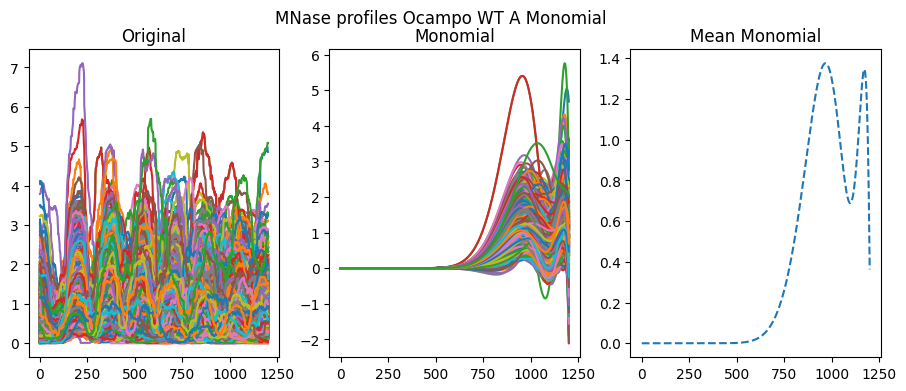

In [14]:
all_basis_ocampo_A = []
for basis, bs_name in zip(all_basis, basis_names):
    all_basis_ocampo_A.append(ocampo_a_fd.to_basis(basis))
    fig, ax = plt.subplots(1, 3, figsize=(11, 4))
    ax[0].plot(wt_ocampo_a.drop(drop_list, axis=1).to_numpy().T)
    all_basis_ocampo_A[-1].plot(chart=ax[1])
    all_basis_ocampo_A[-1].mean().plot(chart=ax[2], linestyle='--')
    fig.suptitle('MNase profiles Ocampo WT A %s' % bs_name)
    ax[0].set_title('Original')
    ax[1].set_title(bs_name)
    ax[2].set_title('Mean %s' % bs_name)
    plt.show()

### Compute ANOVA and Plot Difference For a Single Gene As Example

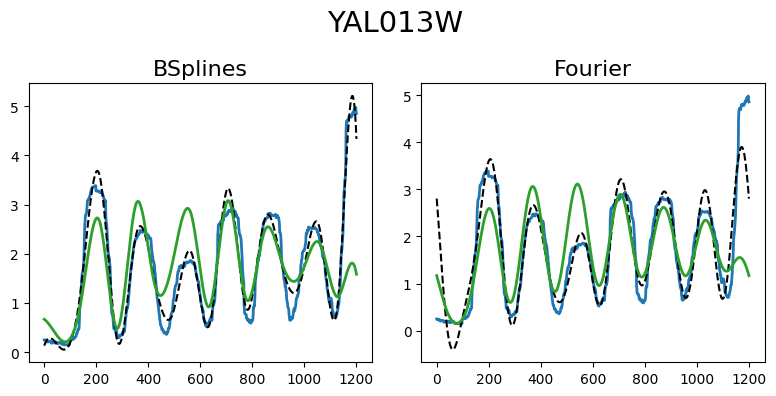

In [15]:
# Remove Monomial cos basis commonly not orthogonal 
# which inhibits use of inner product and inversion of the matrix

basis_fpca_scores_ocampo_a = []
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
explicability_all_basis = []
for basis_ocampo, bs_name, a in zip(all_basis_ocampo_A[:-1], basis_names[:-1], ax.reshape(-1)):
    fpca_ocampo_basis = FPCA(n_components=2)
    basis_fpca_scores_ocampo_a.append(fpca_ocampo_basis.fit_transform(basis_ocampo))
    explicability_basis = []
    for func_idx in range(len(wt_ocampo_a.index)):
        orig_data = wt_ocampo_a_data[func_idx]
        func_estim = (
            basis_ocampo.mean() 
            + fpca_ocampo_basis.components_[0] * basis_fpca_scores_ocampo_a[-1][func_idx][0] 
            + fpca_ocampo_basis.components_[1] * basis_fpca_scores_ocampo_a[-1][func_idx][1]
        )(x_range).reshape(-1)
        explicability_basis.append(calc_explicability(func_estim, orig_data, 20))
    explicability_all_basis.append(explicability_basis)
    a.plot(wt_ocampo_a_data[idx], lw=2)
    basis_ocampo[idx].plot(chart=a, linestyle='--', color='black')
    (basis_ocampo.mean()
     + fpca_ocampo_basis.components_[0] * basis_fpca_scores_ocampo_a[-1][idx][0] 
     + fpca_ocampo_basis.components_[1] * basis_fpca_scores_ocampo_a[-1][idx][1]
    ).plot(chart=a, color='tab:green', lw=2)
    a.set_title(bs_name, fontsize=16)
fig.suptitle(wt_ocampo_a.iloc[idx]['ORF'], fontsize=21)
fig.tight_layout()
plt.show()  

### Difference With Respect to fPCA Scores and Clustering

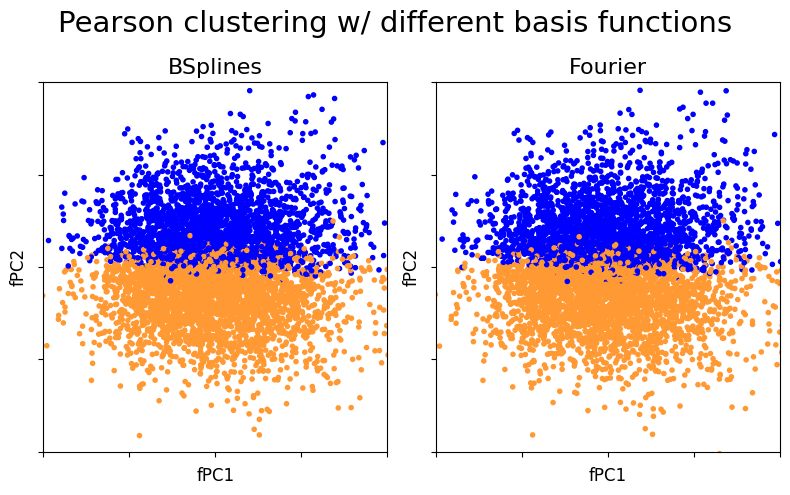

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
for basis_scores, bs_name, a in zip(basis_fpca_scores_ocampo_a, basis_names, ax.reshape(-1)):
    did_swap = False
    if np.sum(np.sign(basis_scores[wt_ocampo_a['cluster'] == 1, 1])) < 0:
        colors = np.flip(colors, axis=0)
        did_swap = True
    a.scatter(*basis_scores.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')
    if did_swap:
        colors = np.flip(colors, axis=0)
    a.set_ylim((-20, 20))
    a.set_xlim((-20, 20))
    a.set_xlabel('fPC1', fontsize=12)
    a.set_ylabel('fPC2', fontsize=12)
    a.set_xticks(np.arange(-20, 21, 10))
    a.set_xticklabels([])
    a.set_yticks(np.arange(-20, 21, 10))
    a.set_yticklabels([])
    a.set_title(bs_name, fontsize=16)
fig.suptitle('Pearson clustering w/ different basis functions', fontsize=21)
fig.tight_layout()
plt.show()

### ANOVA Test

In [17]:
for explanability, bs_name in zip(explicability_all_basis, basis_names):
    # Add scaling for simple readability
    print('ANOVA explainability %s: %.5f' % (bs_name, np.median(explanability) * 1000)) 

ANOVA explainability BSplines: 0.10836
ANOVA explainability Fourier: 0.10707


## Explain WT W/ Only 2 Fourier Functions

In [18]:
fourier_basis_2 = FourierBasis(n_basis=2)

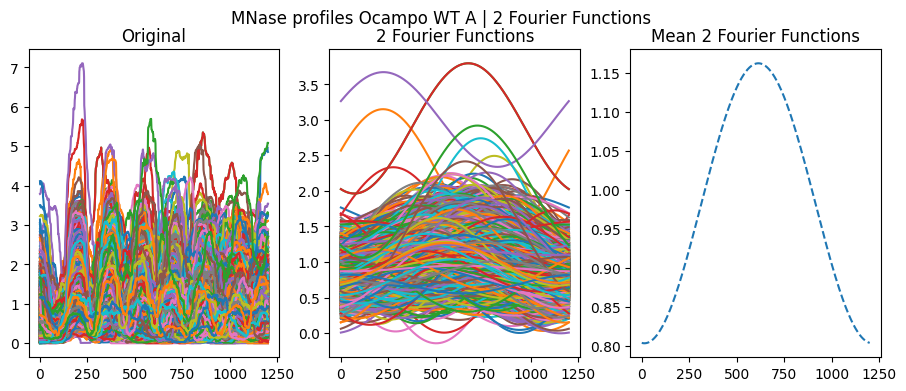

In [19]:
ocampo_fourier_basis_2 = ocampo_a_fd.to_basis(fourier_basis_2)
fig, ax = plt.subplots(1, 3, figsize=(11, 4))
ax[0].plot(wt_ocampo_a.drop(drop_list, axis=1).to_numpy().T)
ocampo_fourier_basis_2.plot(chart=ax[1])
ocampo_fourier_basis_2.mean().plot(chart=ax[2], linestyle='--')
fig.suptitle('MNase profiles Ocampo WT A | 2 Fourier Functions')
ax[0].set_title('Original')
ax[1].set_title('2 Fourier Functions')
ax[2].set_title('Mean 2 Fourier Functions')
plt.show()

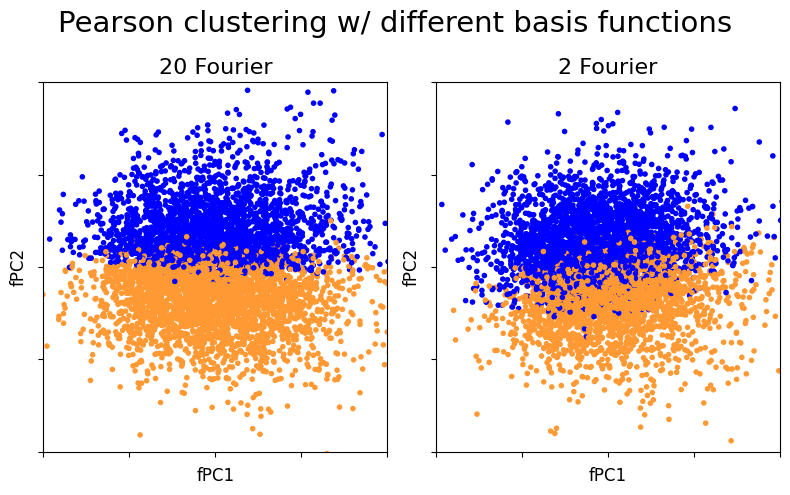

In [20]:
fpca_ocampo_fourier_2 = FPCA(n_components=2)
fourier_2_scores = fpca_ocampo_fourier_2.fit_transform(ocampo_fourier_basis_2)
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
for basis_scores, bs_name, a in zip(
    [basis_fpca_scores_ocampo_a[-1], fourier_2_scores],
    ['20 Fourier', '2 Fourier'],
    ax.reshape(-1)
):
    did_swap = False
    if np.sum(np.sign(basis_scores[wt_ocampo_a['cluster'] == 1, 1])) < 0:
        colors = np.flip(colors, axis=0)
        did_swap = True
    a.scatter(*basis_scores.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')
    if did_swap:
        colors = np.flip(colors, axis=0)
    a.set_ylim((-20, 20))
    a.set_xlim((-20, 20))
    a.set_xlabel('fPC1', fontsize=12)
    a.set_ylabel('fPC2', fontsize=12)
    a.set_xticks(np.arange(-20, 21, 10))
    a.set_xticklabels([])
    a.set_yticks(np.arange(-20, 21, 10))
    a.set_yticklabels([])
    a.set_title(bs_name, fontsize=16)
fig.suptitle('Pearson clustering w/ different basis functions', fontsize=21)
fig.tight_layout()
plt.show()